# EECS 504 Homework 2

## Problem 2: Scene Recognition

In this assignment, you'll learn and practice implementing a CNN image classification model using PyTorch. Specifically, you will train a CNN to solve the scene recognition problem, i.e., the
problem of determining which scene category a picture depicts.

### Getting Started
Make your own copy of this notebook using **File -> Save a copy in Drive**, or if you have iPython installed locally, **File -> Download .ipynb** to do the exercises locally.

### Submitting
When you're ready to submit this problem, first run all of the code to ensure your outputs are included in the submission. Save the `.ipynb` file and submit it to Canvas as `HW2.2_<uniqname>.ipynb`, substituting your uniqname. Be sure your name, uniqname, and UMID are correct in the form fields below. 

**We would also want you to include a pdf version of your final notebook with outputs in your canvas submission, alongwith .ipynb file. You can follow these steps to save a pdf version. After completing your code and running all cells to include output, you can go to File -> Print -> Save as pdf and choose Landscape mode in Colab. Naming convention is same as that for .ipynb file.**


If you want to preview how it will look when we grade it, we'll run a command similar to the one below:

`ipython nbconvert --to html HW2.2_<uniqname>.ipynb`

# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells. **Make sure that your final notebook must contain outputs from Step 4.3 and Step 5.**

Since training the network is long, we won't be running your notebook to calculate those outputs.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101
Using the GPU!


# Problem 2.2 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Construct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [2]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. 
# You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2021-04-09 11:13:38--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  11.1MB/s    in 47s     

2021-04-09 11:14:25 (10.9 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [3]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

## Step 1: Build dataloaders for train, val, and test

In [4]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    '''
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the transformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, 
          each key is mapped to a pytorch dataloader.

    '''

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #  

    # ========= Step 1: build transformations for the dataset ===========
    # You need to construct build a data transformation that does three preprocessings in the order:
    # I.   Resize the image to input_size using transforms.Resize
    # II.  Convert the image to PyTorch tensor using transforms.ToTensor
    # III. Normalize the images with the provided mean and std parameters using transforms.Normalize.
    #      These parameters are accumulated from a large number of training samples.
    # You can use transforms.Compose to combine the above three transformations. 
    # Store the combined transforms in variable 'composed_transform'.
    composed_transform = transforms.Compose([transforms.Resize(input_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean = mean, std = std)])

    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    # We write the remaining part of the dataloader for you.  
    # You are encouraged to go through this.

    # ========= Step 2: We build dataloaders for the downloaded data ===========
    # I.   We use torch.datasets.ImageFolder with the provided data_dir and the data transfomations
    #      you created in step 1 to contruct pytorch datasets for train/val/test 
    # II.  Then we use torch.utils.data.DataLoader to build dataloaders with the constructed pytorch
    #      datasets, you need to enable shuffling for training set. Set num_workers=2 to speed up dataloading.
    # III. Finally, we put the dataloaders into a dictionary

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}
    


    return dataloaders_dict

In [5]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 10000


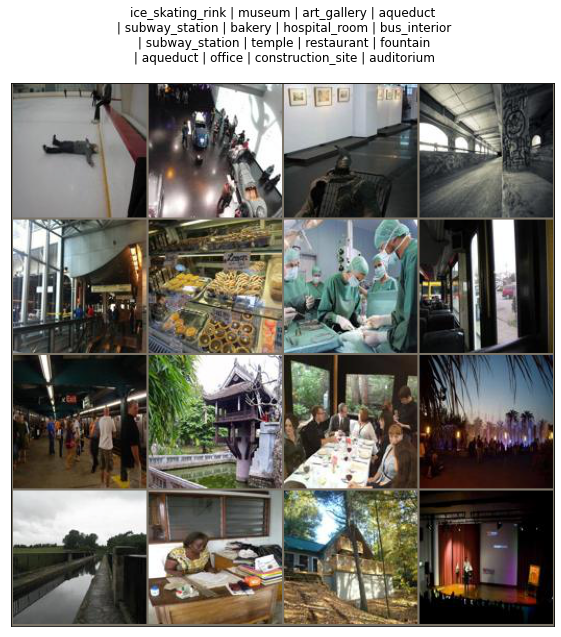

In [6]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## Step 2. Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__

![](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [7]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    '''

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [8]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output channels 
# of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):

    '''
    Return a nn.Sequential object containing all layers to get the features using the CNN.
    (That is, before the Average pooling layer in the two pictures above). 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer should be added 
      after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction layers. 
      For use of torch.nn.Sequential, please refer to PyTorch documents.
    '''
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    # layers = []
    # initial_value = 3
    # for ele in cfg:
    #   if ele == 'M':
    #     layers.extend([nn.MaxPool2d(kernel_size=2, stride=2)])
    #   else:
    #     conv2d = nn.Conv2d(initial_value, ele, kernel_size=3, padding=1)
    #     if batch_norm == False:
    #       layers.extend([conv2d, nn.ReLU(inplace = True)])
    #     else:
    #       layers.extend([conv2d, nn.BatchNorm2d(ele), nn.ReLU(inplace = True)])
    #     initial_value = ele
    # features = nn.Sequential(*layers)

    layers = []
    initial_value = 3
    if batch_norm == False:
      for ele in cfg:
        if ele == 'M':
          layers.extend([nn.MaxPool2d(kernel_size=2, stride=2)])
        else:
          conv2d = nn.Conv2d(initial_value, ele, kernel_size=3, padding=1)
          layers.extend([conv2d, nn.ReLU(inplace = True)])
          initial_value = ele
    else:
      for ele in cfg:
        if ele == 'M':
          layers.extend([nn.MaxPool2d(kernel_size=2, stride=2)])
        else:
          conv2d = nn.Conv2d(initial_value, ele, kernel_size=3, padding=1)
          layers.extend([conv2d, nn.BatchNorm2d(ele), nn.ReLU(inplace = True)])
          initial_value = ele
          
    features = nn.Sequential(*layers)


    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

         
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #
        # Construct the final FC layers using nn.Sequential.
        # NOTE: The avgpool layer has already been defined by us above.
         
        self.classifier = nn.Sequential(
            nn.Linear(3200, 512, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.3, inplace = False),
            nn.Linear(512, 256, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.3, inplace = False),
            nn.Linear(256, 100, bias = True)
        )
        
        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [9]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with the one given
# in the instruction above. 
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## Step 3: Build training/validation loops

You will write a function for training and validating the network. 

In [10]:
def make_optimizer(model):
    '''
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    '''
    
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #
    # Create a SGD optimizer with a learning rate 1e-2, momentum = 0.9
    # HINT:
    # We have imported torch.optim as optim for you
    # Checkout optim.SGD() and initialize with appropriate parameters
    optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9)


    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return optimizer

def get_loss():
    '''
    Returns:
        criterion: pytorch loss. 
    '''

    
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #
    # Create an instance of the cross entropy loss function 
    # The code should be a one-liner.
    # Hint: 
    # See criterion in pytorch_tutorial discussion and find the function in nn
    # for cross entropy loss function. 
    criterion = nn.CrossEntropyLoss()
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return criterion

In [11]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    '''
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    '''

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 
                # ============== YOUR CODE HERE ============== #
                # Please read all the inputs carefully!
                # For "train" phase: 
                # (i)   Compute the outputs using model
                #       Also, use outputs to calculate predicted class by model,
                #       Store the predicted class in variable 'preds'
                #       (Think argmax of outputs across a dimension)
                #       torch.max() might help!
                # (ii)  Calculate the loss using criterion. Store it as 'loss' 
                # (iii) Update the model parameters

                # Don't forget to zero the gradients for each iteration!
                
                # For "val" phase, same as train but without backprop 
                # Compute the outputs (Same as "train", calculate 'preds' also), 
                # Calculate the loss, store it as 'loss'
                #Since the size of labels.data is 128, the output should also have size of 128
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                result = torch.max(outputs, 1)
                preds = result[1]
                if phase != 'val':
                  loss.backward()
                  optimizer.step()
                # ============== END OF CODE ================= # 
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # ================================ IMPORTANT ===============================================
                # Lossing connection to colab will lead to loss of trained weights.
                # You can download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to train the neural networks again.
                # ==========================================================================================
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))
    
    ## save training accuracy values
    if model_name == 'MiniVGG':
      pickle.dump(tr_acc_history, open('tr_his.pkl', 'wb'))
      pickle.dump(val_acc_history, open('val_his.pkl', 'wb'))
    elif model_name == 'MiniVGG-BN':
      pickle.dump(tr_acc_history, open('tr_his_BN.pkl', 'wb'))
      pickle.dump(val_acc_history, open('val_his_BN.pkl', 'wb'))

    return model, tr_acc_history, val_acc_history

## Step 4. Train MiniVGG and MiniVGG-BN

In [12]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloders and criterion function
input_size = 64 # do not change this
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

## Step 4.1  Run training - MiniVGG
Please be patient here - running training for 20 epochs here would take about 25 minutes on Colab Tesla K80 GPU 

In [13]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.4322 Acc: 0.0245


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 4.1608 Acc: 0.0579
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.9290 Acc: 0.0860


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.7271 Acc: 0.1154
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.6035 Acc: 0.1391


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.4668 Acc: 0.1608
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.3589 Acc: 0.1806


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.1767 Acc: 0.2131
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.1792 Acc: 0.2134


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0604 Acc: 0.2375
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.0166 Acc: 0.2468


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9772 Acc: 0.2534
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8851 Acc: 0.2695


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8703 Acc: 0.2712
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7631 Acc: 0.2934


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8735 Acc: 0.2840
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6532 Acc: 0.3166


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8077 Acc: 0.2908
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5579 Acc: 0.3352


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7943 Acc: 0.2970
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4670 Acc: 0.3543


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8027 Acc: 0.3039
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3566 Acc: 0.3765


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7543 Acc: 0.3064
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2698 Acc: 0.3953


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8058 Acc: 0.3031
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1781 Acc: 0.4140


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7954 Acc: 0.3046
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1077 Acc: 0.4251


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8523 Acc: 0.3093
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0415 Acc: 0.4429


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8463 Acc: 0.3098
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.9581 Acc: 0.4608


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9395 Acc: 0.3003
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.9020 Acc: 0.4708


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9789 Acc: 0.2984
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.8443 Acc: 0.4858


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0013 Acc: 0.2927
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.7961 Acc: 0.4961


100%|██████████| 79/79 [00:07<00:00, 10.82it/s]

val Loss: 3.0308 Acc: 0.2922
Best val Acc: 0.309800


## Step 4.2 Run training - MiniVGG-BN
Please be patient here - running training for 20 epochs here would take about 25 minutes on Colab Tesla K80 GPU

In [14]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.0578 Acc: 0.0685


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.6935 Acc: 0.1227
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.5074 Acc: 0.1482


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.3414 Acc: 0.1824
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.2729 Acc: 0.1903


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.2710 Acc: 0.2045
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.1031 Acc: 0.2246


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0307 Acc: 0.2445
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9609 Acc: 0.2523


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9534 Acc: 0.2554
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8357 Acc: 0.2763


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8200 Acc: 0.2842
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7284 Acc: 0.2998


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7280 Acc: 0.2999
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6285 Acc: 0.3185


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6822 Acc: 0.3153
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5334 Acc: 0.3396


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7399 Acc: 0.3095
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4529 Acc: 0.3571


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6070 Acc: 0.3334
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3692 Acc: 0.3746


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6894 Acc: 0.3233
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2936 Acc: 0.3903


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5738 Acc: 0.3432
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2186 Acc: 0.4075


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5916 Acc: 0.3433
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1476 Acc: 0.4214


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5611 Acc: 0.3570
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0586 Acc: 0.4384


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5322 Acc: 0.3565
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.9903 Acc: 0.4559


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5716 Acc: 0.3558
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.9192 Acc: 0.4693


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5709 Acc: 0.3552
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.8457 Acc: 0.4866


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5401 Acc: 0.3669
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.7756 Acc: 0.4992


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6197 Acc: 0.3544
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.7157 Acc: 0.5156


100%|██████████| 79/79 [00:07<00:00, 10.79it/s]

val Loss: 2.6322 Acc: 0.3579
Best val Acc: 0.366900


# Helpful information
If you had run all cells uptil Step 4.2 successfully (completed training) and then had to restart runtime, you won't lose your training weights.

After runtime restart, you can test your model and generate all outputs by running all cells except Step 4.1 and Step 4.2

However, if you exit Colab, you would be required to run training again.

A good practice would to download trained model weights (weights -> MiniVGG.pth and weights -> MiniVGG-BN.pth) from files section in Colab to your local machine.

## Step 4.3 Plot model accuracies

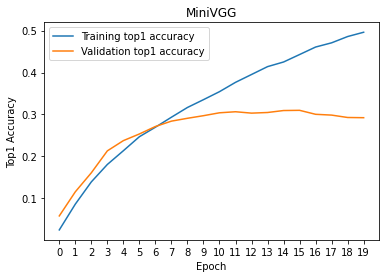

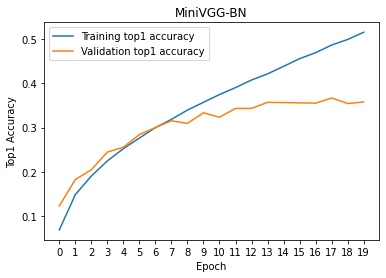

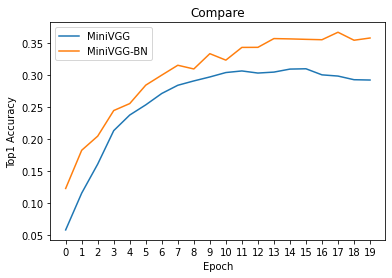

In [15]:
# visualize the training / validation accuracies

x = np.arange(num_epochs)

# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, tr_his)
plt.plot(x, val_his)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, tr_his_BN)
plt.plot(x, val_his_BN)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, val_his)
plt.plot(x, val_his_BN)
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

###__Summarize the effect of batch normalization:__

Please write a few sentences here to summarize the effect of batch nomalization.

## Step 5. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [16]:
def accuracy(output, target, topk=(1,)):
    '''
    Computes the accuracy over the k top predictions for the specified values of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    '''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        #correct = pred.eq(target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)

        res = []
        for k in topk:
            #correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [17]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features).to(device)
vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_BN = VGG(features).to(device)
vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))

print('VGG BN model')
test(vgg_BN, dataloaders['test'])

print('VGG model')
test(vgg, dataloaders['test'])

VGG BN model
Top-1 accuracy 36.23%, Top-5 accuracy 66.51%
VGG model
Top-1 accuracy 30.82%, Top-5 accuracy 60.23%
